#  Churn Prediction and Analysis

The purpose of this notebook is to use classification models in order to predict if a customer is churned.  Those models will then be used to examine which features most impact churn and what business insights can be derived from that. 

1. Define Churn

2. Examine general statistics for churn/no churn.

3. Prepare data for modeling

4. Examine the results of a dummy classifier.

5. Compare results from LinearSVC, K-NN, SVC, and Random Forest Classifiers.

6. Examine SHAP feature weights in order to uncover insights from models.

In this instance I would generally start with a random forest model since that tends to be my go-to.  However in order to avoid this bias we're going to rely on this chart provided by Sci-Kit learn for choosing a model and ensure that I'm actually trying models I would typically pass over. 

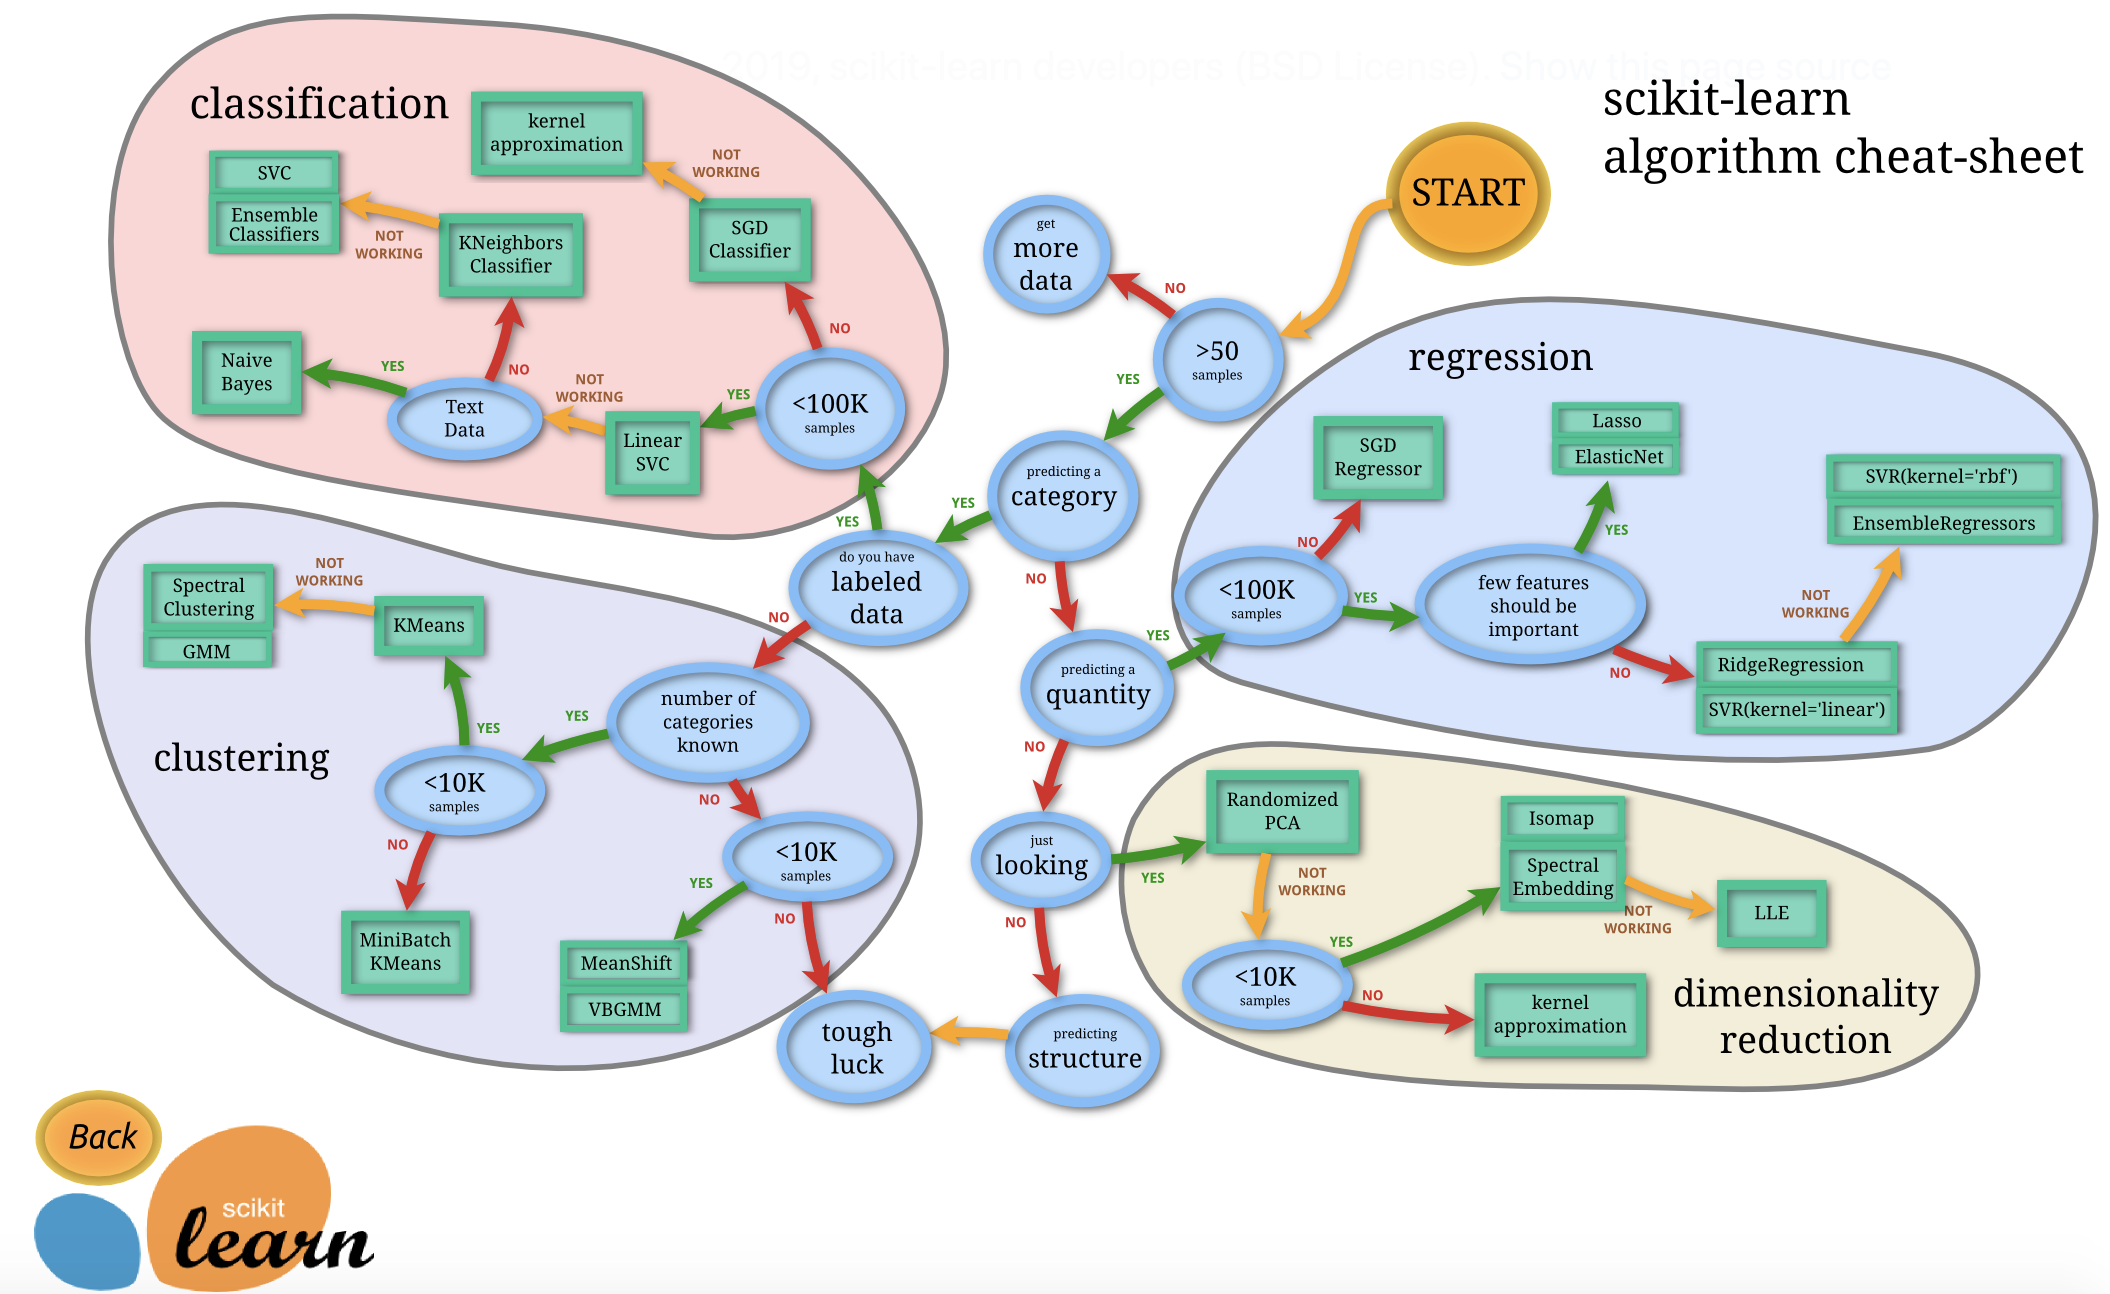

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import warnings
import shap

warnings.filterwarnings('ignore')
%matplotlib inline
# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("poster")
#setup Pandas
pd.set_option('display.max_columns', None)

In [2]:
# Load cleaned data
df = pd.read_parquet('../Data/Cleaned_Customer_Data')
# Load correlation thresholds
corr = pd.read_csv('../Data/Correlation_Thresholds', index_col = 'Unnamed: 0')

In [3]:
df.head()

,Age,Marital_status,Income,Homeowner_status,Household_comp,Household_size,Kids,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Most_freq_dept,Least_freq_dept,Count_sub_cagtegory,Most_freq_product,Least_freq_product,High_volume_product,PercentPrivate,%_products_preferred_dept,%_purchases_product_displayed,%_purchases_product_mailer,%_baskets_product_mailer,%_baskets_product_displayed,Avg_quantity_purchased,Avg_basket_sales_value,Max_basket_sales_value,Min_basket_sales_value,Total_num_baskets,Avg_num_items,Max_num_items,Min_num_items,Avg_manu_disc,Max_manu_disc,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Min_loyal_disc,Max_loyal_disc,Num_stores_visited,Most_freq_store,Most_freq_time,First_active_day,Last_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,2,8,0.25,5,662,0.007553,3.0,4.0,1.0,0.375000,0.5,0.125000,677,13,GROCERY,FLORAL,303,825123.0,1051883.0,856942.0,0.117545,0.652661,0.095541,0.114650,0.114650,0.095541,1.156340,50.350698,133,0,86,23.220930,62,1,0.304070,2.2,0.936744,6.84,8.105116,0.0,23.30,2,436.0,1456.0,51,706,5,0.120956,4330.16,1.264706,7.705882
2,0,0,0,0,0,0,0,0,1,0.00,0,209,0.000000,1.0,0.0,0.0,1.000000,0.0,0.000000,546,12,GROCERY,FLORAL,299,1077555.0,864996.0,8090521.0,0.235294,0.739696,0.091036,0.109244,0.109244,0.091036,1.168067,43.429778,153,3,45,18.533333,71,1,0.000000,0.0,0.200000,2.50,7.444222,0.0,38.77,5,401.0,1904.0,103,668,43,0.063291,1954.34,1.285714,12.840909
3,0,0,0,0,0,0,0,0,3,0.00,0,417,0.000000,2.0,0.0,1.0,0.666667,0.0,0.333333,516,12,GROCERY,,220,882830.0,5978648.0,6534178.0,0.187636,0.760797,0.215835,0.235358,0.235358,0.215835,9.262473,56.451277,286,2,47,181.702128,6949,2,0.421277,10.6,1.301915,30.24,14.365106,0.0,79.53,3,401.0,1549.0,113,703,8,0.066104,2653.21,1.270270,12.826087
4,0,0,0,0,0,0,0,0,1,0.00,0,209,0.000000,1.0,0.0,0.0,1.000000,0.0,0.000000,164,9,GROCERY,NUTRITION,110,836163.0,894503.0,6773204.0,0.152824,0.554054,0.083056,0.066445,0.066445,0.083056,1.269103,40.003667,126,2,30,12.733333,53,1,0.000000,0.0,0.083333,2.50,3.855000,0.0,27.41,6,298.0,1452.0,104,627,84,0.042194,1200.11,1.153846,18.034483
5,0,0,0,0,0,0,0,0,0,0.00,0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,199,9,GROCERY,PASTRY,125,1002499.0,1009449.0,13986405.0,0.216216,0.380793,0.139640,0.108108,0.108108,0.139640,1.103604,19.476500,60,0,40,6.125000,22,1,0.000000,0.0,0.000000,0.00,2.958250,0.0,20.61,3,374.0,1540.0,85,703,8,0.056259,779.06,1.481481,15.846154


In [4]:
corr.head(3)

,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Count_sub_cagtegory,PercentPrivate,%_products_preferred_dept,%_purchases_product_displayed,%_purchases_product_mailer,%_baskets_product_mailer,%_baskets_product_displayed,Avg_quantity_purchased,Avg_basket_sales_value,Max_basket_sales_value,Min_basket_sales_value,Total_num_baskets,Avg_num_items,Max_num_items,Min_num_items,Avg_manu_disc,Max_manu_disc,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Min_loyal_disc,Max_loyal_disc,Num_stores_visited,First_active_day,Last_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
CampaignsRedeemed,high,low,mid,high,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
CampaignsSent,low,high,low,low,mid,low,mid,high,low,low,low,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
Percent_CampaignRedeemed,mid,low,high,mid,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 1 to 2500
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            2500 non-null   object 
 1   Marital_status                 2500 non-null   object 
 2   Income                         2500 non-null   object 
 3   Homeowner_status               2500 non-null   object 
 4   Household_comp                 2500 non-null   object 
 5   Household_size                 2500 non-null   object 
 6   Kids                           2500 non-null   object 
 7   CampaignsRedeemed              2500 non-null   int64  
 8   CampaignsSent                  2500 non-null   int64  
 9   Percent_CampaignRedeemed       2500 non-null   float64
 10  CouponRedeemed_Count           2500 non-null   int64  
 11  CouponSent_Count               2500 non-null   int64  
 12  Percent_CouponsRedeemed        2500 non-null   f

### 1. Defining Churn

My instinct is to simply study churn over the entire period, and define churn as having gone more than a month without purchasing from one of the multiple grocery store locations.   Generally speaking this is how I shop - once a week to a grocery store, but there are three options in my area.  Sometimes I'll go a few months without visiting one of them but will go back when I need a specific item and then re-enter them into the 'rotation'.  However, this is how I shop and not neccessarily indicative of how others will shop. 

Ideally I could speak to someone at this store to assess how long produce and other essential purchases from a grocery store will last, however that's not possible so I'll take a look and see which definition of churn will allow me to provide insights that are both sensitive to not over-defining churn, but also can provide a significant impact to revenue. The typical person will have to shop at least twice a month - fresh produce won't keep longer than 2-3 weeks. 

However there are several other options which can be considered:

1. Churn is allowing 30 days (1 month) to pass without visiting one of the grocery stores (This infers that a customerhas  shopped 2 times at a different store without returning to the grocery store being examined).


2. Churn is no longer shopping from this brand of grocery 1 year after the first active day (This limits churn to those who are never 'resurrected').


3. Churn is allowing 90 days to pass without visiting one of the grocery stores (This infers that a customer shopped 6 times at different store, and would capture the behavior which I personally exhibit).


4. Some other definition of churn based on patterns noticed in the data.

In [6]:
# dropping Last_active_day since this is the inverse of Recency and identifying the max value of Recency
df = df.drop('Last_active_day', axis=1)
df['Recency'].max()

657

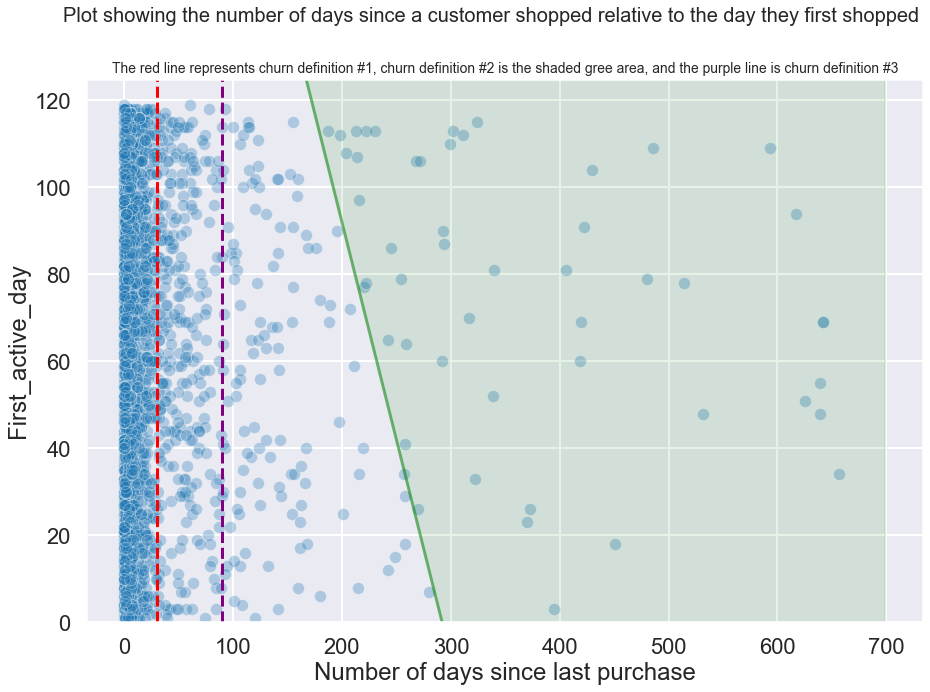

In [7]:
plt.figure(figsize=(15,10))
plt.tight_layout()
g = sns.scatterplot(x='Recency', y='First_active_day', data=df[df['First_active_day'] < 125], alpha=0.3)
# set ylimit at 125, there were five data points above this and it dramaticaly skewed the visualization of the data
ax = g.axes
ax.set_ylim(0,125)
# Creating a line to mark those customers who haven't visited in 30 days
_1 = plt.axvline(x=30, linestyle='--', color='red')
# creating a line to mark those customers who will be churned under condition #2
x = np.arange(0, 700, 1)
_2B = plt.plot(x, ((-1*x)+292), alpha = 0.5, color='g')
y = []
for item in x:
    point = ((-1*item)+292)
    y.append(point)
plt.fill_between(x, y, 125, color='green', alpha=0.1)
# Creating a line to mark those customers who haven't visited in 90 days
_3 = plt.axvline(x=90, linestyle='--', color='purple')

plt.suptitle('Plot showing the number of days since a customer shopped relative to the day they first shopped', 
            size='small')
plt.title('The red line represents churn definition #1, churn definition #2 is the shaded gree area, and the purple '
          'line is churn definition #3', size='xx-small')
plt.xlabel('Number of days since last purchase');

In [8]:
x = len(df[df['Recency']>30])
y = len(df[df['Recency']>90])
z = len(df[df['Recency'] > df['First_active_day']+365])

print('Churn definition #1 will have ', str(round(x/len(df)*100, 2)) , '% of households marked as churn')
print('Churn definition #2 will have ', str(round(z/len(df)*100, 2)) ,'% of households marked as churn')
print('Churn definition #3 will have ', str(round(y/len(df)*100, 2)) ,'% of households marked as churn')

Churn definition #1 will have  18.16 % of households marked as churn
Churn definition #2 will have  0.56 % of households marked as churn
Churn definition #3 will have  6.84 % of households marked as churn


I would seem that most customers have shopped at this grocery store chain at least 1 year after their initial purchase from the store, perhaps this could be a good opportunity to examine churn since these customers clearly haven't been revived.  However addressing the cause for these customer's churn won't help the bottom line of the store since it's such a small percentage of overall households.  

What would be better is to focus on what will capture insights that will drive customers to purchase more frequently.  In order to do so I'll look at 90-day churn since these customers could conceivably return but have also purchased from another store multiple times without returning to the grocery store being examined.  

In [9]:
df['churn'] = 0
df['churn'][df['Recency'] > 90] = 1
np.mean(df['churn'])*100

6.84

### Examining Churn Statistics

Next I'll need to take a look at the descriptive statistics for each group and identify if anything stands out between the groups. 

In [10]:
# Dropping all categorical features since we only have that data for 670 households, and dropping Recency since 
# that is what determines churn
groupby = df.drop('Recency', axis=1).select_dtypes(np.number).groupby('churn').mean()
groupby

,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Count_sub_cagtegory,Most_freq_product,Least_freq_product,High_volume_product,PercentPrivate,%_products_preferred_dept,%_purchases_product_displayed,%_purchases_product_mailer,%_baskets_product_mailer,%_baskets_product_displayed,Avg_quantity_purchased,Avg_basket_sales_value,Max_basket_sales_value,Min_basket_sales_value,Total_num_baskets,Avg_num_items,Max_num_items,Min_num_items,Avg_manu_disc,Max_manu_disc,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Min_loyal_disc,Max_loyal_disc,Num_stores_visited,Most_freq_store,Most_freq_time,First_active_day,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.378274,3.039931,0.069925,0.990125,332.045513,0.001830,1.671533,1.124088,0.244311,0.429349,0.196291,0.037734,587.179906,13.262774,256.298841,1.157894e+06,4.351873e+06,4.492330e+06,0.289519,0.630920,0.107045,0.162645,0.162645,0.107045,93.198532,31.806759,144.746243,1.284672,116.115500,736.206177,8556.295835,1.164878,0.027574,0.743637,0.149476,3.771812,5.728885,0.032958,35.083074,5.619579,2743.080721,1585.910262,66.021898,0.163313,3392.909708,1.950512,13.336176
1,0.046784,0.748538,0.005556,0.070175,97.251462,0.000078,0.502924,0.216374,0.029240,0.177026,0.046658,0.004386,198.403509,9.000000,110.888889,1.193303e+06,3.413839e+06,4.172396e+06,0.284028,0.634334,0.108601,0.155727,0.155727,0.108601,76.802085,29.087433,94.818713,4.596491,35.385965,597.292341,4859.204678,2.157895,0.010438,0.203918,0.080305,1.246023,5.494072,0.277953,22.969532,3.356725,2438.157895,1594.286550,64.842105,0.049769,908.633743,1.545025,38.943621


In [11]:
series = pd.Series(index=groupby.columns)
for item in series.index:
    
    pct_diff = np.abs(100 - (groupby.loc[1, item] / groupby.loc[0, item] *100))
    series[item] = pct_diff

In [12]:
series.sort_values(ascending=False)

Min_loyal_disc                   743.346849
Min_basket_sales_value           257.795056
Avg_shopping_lag                 192.014897
Percent_CouponsRedeemed           95.740150
CouponRedeemed_Count              92.912463
Percent_CampaignRedeemed          92.054979
PercentTypeC                      88.376695
TypeC                             88.031737
CampaignsRedeemed                 87.632342
Min_num_items                     85.246474
TypeB                             80.751120
PercentTypeB                      76.230065
CampaignsSent                     75.376483
Monetary                          73.219631
Max_manu_disc                     72.578261
CouponSent_Count                  70.711406
TypeA                             69.912408
Frequency                         69.525201
Total_num_baskets                 69.525201
Max_coupon_disc                   66.964859
Count_products                    66.210780
Avg_manu_disc                     62.146954
PercentTypeA                    

Here we can see those features which exhibit the strongest difference between the churned and not-churned classes.  Anything over 100 is a feature where the value is larger for churned classes than non-churned, anything less than 100 is where the values for the non-churned class is larger.  The smaller the value the closer the two classes are. 

### Preparing the data set for modelling

Creating a train/test split and scaling the data. I'm going to eliminate the categorical data since I have demographic information for less than 50% of the data set.

In [13]:
# dropping the column used to calculate churn, as well as several other features which are highly correlated or 
# are categorical features represented by numeric values. 
data = df.drop(['Recency', 'Total_num_baskets', 'First_active_day', 'Avg_trips_week', 'High_volume_product', 
                'Most_freq_product', 'Least_freq_product', 'Most_freq_store'], axis=1).select_dtypes(np.number)
#cols = data.columns
#scaler = MinMaxScaler()
#data = scaler.fit_transform(data)
#data = pd.DataFrame(data, columns = cols)
X = data.drop('churn', axis=1)
y = data['churn']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Checking how well a dummy classifier does

Next, I want to see how well a dummy classifier performs before I start working with other models.  If I find that there is marginal improvement over a dummy classifier I'll know that I need to take some steps to handle the imbalance between classes. 

In [15]:
dummy = DummyClassifier(random_state=42)
dummy.fit(x_train, y_train)
dpred = dummy.predict(x_test)

print(classification_report(y_test, dpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       466
           1       0.00      0.00      0.00        34

    accuracy                           0.93       500
   macro avg       0.47      0.50      0.48       500
weighted avg       0.87      0.93      0.90       500



Here, as expected, the dummy classifier predicted all households to be not churned, and thuse had a great accuracy score but predicted none of the churned housholds correctly.   We'll be looking to see precision and recall scores improve. 

### Examining results with a LinearSVC model. 

In [16]:
linear = LinearSVC(random_state=42)
linear.fit(x_train, y_train)
lpred = linear.predict(x_test)

print(classification_report(y_test, lpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       466
           1       0.36      0.15      0.21        34

    accuracy                           0.92       500
   macro avg       0.65      0.56      0.58       500
weighted avg       0.90      0.92      0.91       500



This is still not predicting the churned households at all. 

### Examining results with KNN model.

In [17]:
knn = KNeighborsClassifier(weights = 'distance')
knn.fit(x_train, y_train)
kpred = knn.predict(x_test)

print(classification_report(y_test, kpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       466
           1       0.33      0.15      0.20        34

    accuracy                           0.92       500
   macro avg       0.64      0.56      0.58       500
weighted avg       0.90      0.92      0.91       500



This is an improvement over the dummy classifier and Linear Support-Vector Classifier in that the K-nearest Neighbors model is actually making some predictions for the target class.  However it isn't predicting accurately and can hardly considered to be accurate.  This model is only accurately predicting churn 3\% of the time. 

### Examining the results of an SVC model

In [18]:
svc = SVC(random_state=42)
svc.fit(x_train, y_train)
spred = svc.predict(x_test)

print(classification_report(y_test, spred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       466
           1       0.00      0.00      0.00        34

    accuracy                           0.93       500
   macro avg       0.47      0.50      0.48       500
weighted avg       0.87      0.93      0.90       500



Similar to how a Linear Support-Vector Classifier performs out of the box, the Support-Vector Classifier is not making any predictions for the target class and is therefore useless. 

### Examining Results of a decision tree ensemble model

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rpred = rf.predict(x_test)

print(classification_report(y_test, rpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       466
           1       0.62      0.29      0.40        34

    accuracy                           0.94       500
   macro avg       0.79      0.64      0.68       500
weighted avg       0.93      0.94      0.93       500



In [20]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)
gpred = gb.predict(x_test)

print(classification_report(y_test, gpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       466
           1       0.79      0.44      0.57        34

    accuracy                           0.95       500
   macro avg       0.87      0.72      0.77       500
weighted avg       0.95      0.95      0.95       500



WOW.  So while the other modes didn't predict ANY of the churned class, while both ensemble models have predicted them, and are predicting churn with a much higher weighted accuracy of 94\% for a Random Forest, and 95\% for a Gradient Boosting Classifier. 

Regardless of which metric is examined, the Gradient Boosting model outperforms the random forest model in almost every situation. 

Since the entire point of this is to examine what is causing households to churn, I'll start by optimizing the gradient boosting model in order to improve recall performance. 

In [21]:
print('\'Area Under Curve\' score for the gradient boosting model is: ', str(roc_auc_score(y_test, gpred)))

'Area Under Curve' score for the gradient boosting model is:  0.7162963898005554


In [22]:
params = {'n_estimators':np.arange(50,500), 'max_depth':np.arange(2,len(x_train.columns)), 
          'min_samples_split': np.arange(2,len(x_train.columns)), 'min_impurity_decrease':[0.0001, 0.001, 0.01]}
gb = GradientBoostingClassifier(random_state=42)
gradient = RandomizedSearchCV(gb, param_distributions=params, scoring = 'recall', n_iter=60)
gradient.fit(x_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

GB best score:  0.328042328042328
GB best parameters:  {'n_estimators': 431, 'min_samples_split': 37, 'min_impurity_decrease': 0.0001, 'max_depth': 26}


In [32]:
gb = GradientBoostingClassifier(n_estimators=431, min_samples_split=37, min_impurity_decrease=0.0001, max_depth=26, 
                               random_state=42)
gb.fit(x_train, y_train)
gpred_opt = gb.predict(x_test)

print(classification_report(y_test, gpred_opt, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       466
           1       0.75      0.35      0.48        34

    accuracy                           0.95       500
   macro avg       0.85      0.67      0.73       500
weighted avg       0.94      0.95      0.94       500



The optimized model is accurately predicting hosueholds which are in the churn class more frequently, while not sacrificing precision with predicting the churn class.  While a marginal overall improvement on the original gradient boosting model, this is important for ensuring that accurate insights are found. 

### Examining SHAP feature weights alongside the built in Gradient Boosting feature importances.

Well clearly the gradient boosting model is the one to choose, with 100% accuracy across the board.  While this is suspiscious in that the rsults are so good right away, it will mean that any insights gained will be incredibly useful. 

Recall that these features will identify with high accuracy which households will churn for at least 90 days. 

In [33]:
gbweight = gb.feature_importances_
gbweight = pd.Series(gbweight, index = x_train.columns)
gbweight.sort_values(ascending=False).head(10)

Frequency                 0.300873
Avg_shopping_lag          0.158354
Avg_quantity_purchased    0.044082
Count_sub_cagtegory       0.042718
Monetary                  0.036565
PercentPrivate            0.032232
Count_products            0.031000
Avg_loyalty_disc          0.027405
Avg_basket_sales_value    0.027195
Avg_num_items             0.026616
dtype: float64

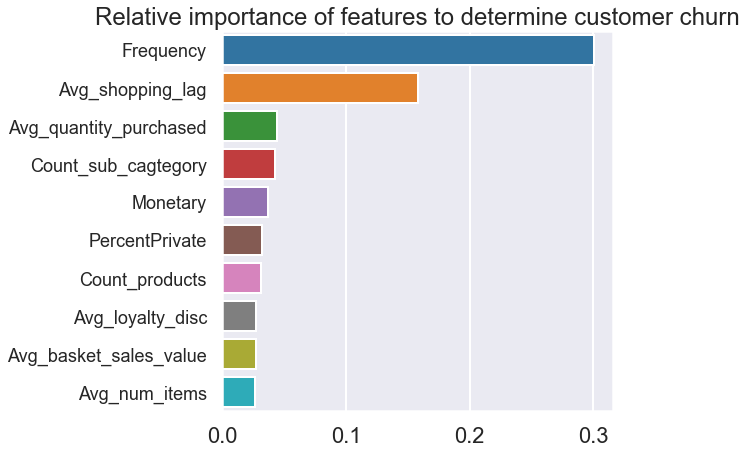

In [34]:
plt.figure(figsize=(7,7))

topten = list(gbweight.sort_values(ascending=False).head(10).index)
g = sns.barplot(x= gbweight.sort_values(ascending=False).head(10),y = topten, orient='h')
plt.title('Relative importance of features to determine customer churn')
g.set_yticklabels(topten, size = 18);

Here we can see that the frequency with which someone shops at the grocery store, as well as the average time between shopping trips are the two biggest factors for determining churn in this model. You can see that the total amount of money which a customer has spent, the time they frequently shop at, and the percent of private brands they purchase are all additional indicators for churn as well.  

Next we'll calculate the SHAP values for each household and examine HOW these features impact churn.

In [35]:
# Computing SHAP values
exp = shap.Explainer(gb, x_train)
values = exp(x_train)

 97%|=================== | 1948/2000 [00:14<00:00]       

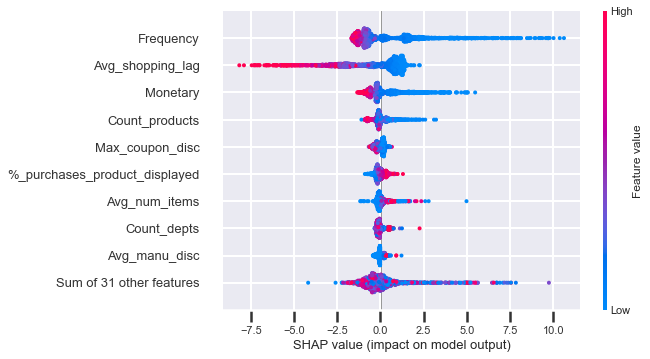

In [36]:
shap.plots.beeswarm(values)

This household was correctly predicted as retained


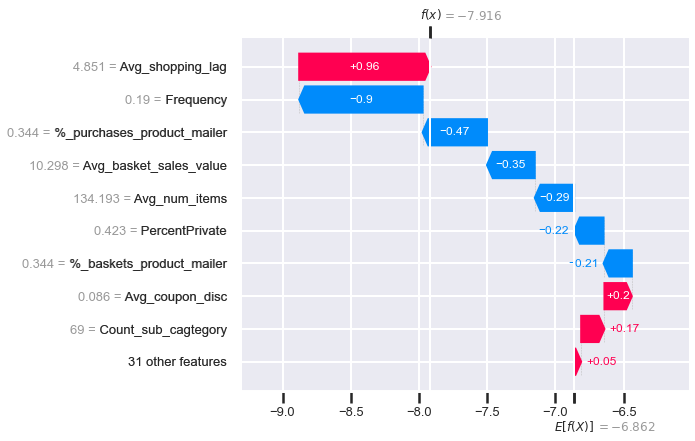

In [37]:
# Plotting the individual values for the first household.
y_test = list(y_test)
if gpred_opt[0] == 1:
    p = 'churn'
else: p = 'retained'
if gpred_opt[0] == y_test[0]:
    print('This household was correctly predicted as', p)
else: print('This model incorrectly predicted his household')
    
shap.plots.waterfall(values[0])

#### Initial Shapley Value Findings

First, I need to explain what the numbers on this graph indicate.  The model expects a value of -5.91 *(Labelled as: E\[f(x)\])* for each household, if the shapley values for a given household taken together increase the value, then the model will predict a household as churned.  The f(x) value at the top of the plot is the value arrived at for this household after cumulatively adding all shapley values for each feature.   This allos us to interpret which features influence a model the most when taken in aggregate.  When examined individually it presents a strong case which we can use in order to better understand what caused the model to make a correct or incorrect determination. 

1. On average this household purchases from this grocery store once every 4.8 days, which resulted in a Shapley value of 0.68 and influenced the model more than any other feature to predict this household as churned.  


2. This household also has a low count of sub_categories they purchased (relative to other households).  This resulted in a large positive shapley value for the household for this feature, and also encouraged the model to predict the household as churned.




This household was correctly predicted as churn


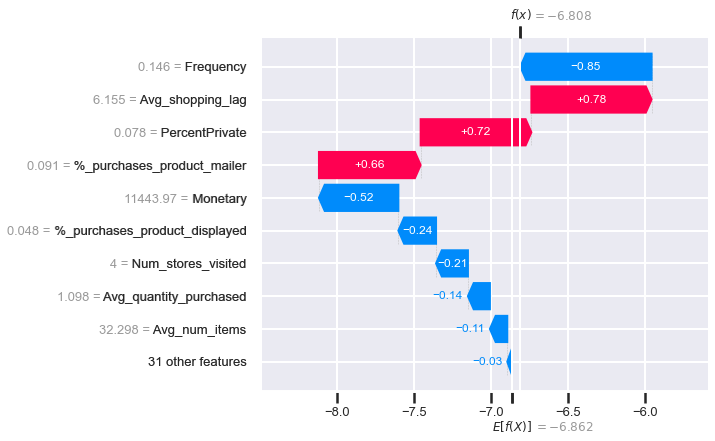

In [38]:
# Plotting the individual values for the first household.
if gpred_opt[15] == 1:
    p = 'churn'
else: p = 'retained'
if gpred_opt[15] == y_test[15]:
    print('This household was correctly predicted as', p)
else: print('The model incorrectly predicted this household as retained')
    
shap.plots.waterfall(values[15])

#### Shapley values when incorrectly predicting a household as retained



This household was correctly predicted as retained


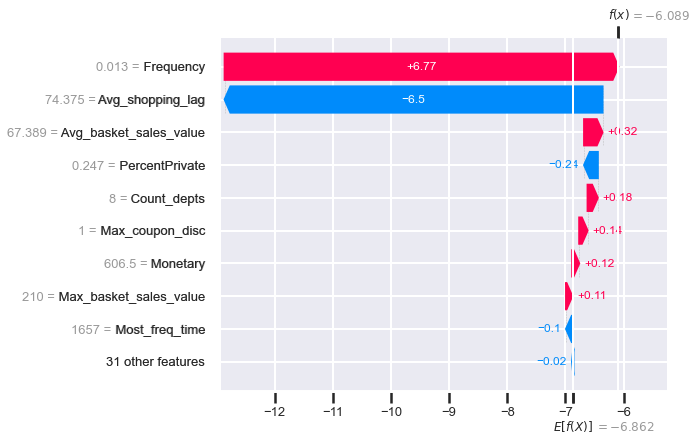

In [39]:
# Plotting the individual values for the first household.
if gpred_opt[27] == 1:
    p = 'churned'
else: p = 'retained'
if gpred_opt[27] == y_test[27]:
    print('This household was correctly predicted as', p)
else: print('This model incorrectly predicted his household')
    
shap.plots.waterfall(values[27])

In [31]:
""" Why is this household predicted as churned when the f(x) value is much lower than the expected value."""

' Why is this household predicted as churned when the f(x) value is much lower than the expected value.'

### Insights from predicting churn:

These two plots provide several insights from the churn model and provide powerful insights that can help inform stakeholder's decision making in order to limit or prevent churn: 


1. First, and most clearly, low frequency shoppers are far more likely to churn.  If you examine the SHAP value plot for this feature we can see that while high frequency is always associated with decreased likelihood of churn; low frequency generally predicts churn as we've defined it, however it is not always associated with churn. 


2. Average shopping lag, or the average time between trips, is almost the inverse of Frequency.  High 'lag times' always influence the mode to classify a customer as churned, while lower lag times generally influcence the model to predict a user as retained.


The insight to be drawn from these two features is that in order to reduce churn the grocery chain needs to encourage customers to shop more frequently and with less lag time between shopping trips.  

3. Perhaps counterintuitively, a high percentage of shopping trips where a product on display in the store was purchased (%\_baskets_product_displayed) influences the model to predict a household as churned. This is perhaps because these shoppers are influences by marketing efforts and thus can be influenced to shop elsewhere. This could also be because these shoppers don't have a particular loyalty to one product or another, which extends to not only what they buy but where they buy it. 


4. Similar to the findings of the clustering models, high loyalty discounts are associated with retained customers. 

### Recommendations: 

1. Further study the shopping behavior of high frequency shoppers, and ascertain what products/patterns they exhibit.  This will allow us to target marketing efforts to influence customers to shop more frequently and with less time between trips.  Note that this does NOT mean encourage customers to spend more on each trip, but rather to make shopping trips occur more often. 

2. Study further the customers who purchased a high percentage of products on display.  Were the products they purchased on display cheaper than other similar products they have purchased?  Why is it that purchasing marketed goods causes the model to predict a customer as churned?  This is something that we can use alongside the results of recommendation /#1 to potentially influence behavior that may cause frequency and average shopping lag to decrease, and ultimately reduce churn. 

3. Continue to push the loyalty program, higher loyalty discounts result in more retained customers.  Potentially begin to employ pricing techniues such as 'instant markdown' or visually contrasting normal vs loyalty prices. 